# Анализ оттока клиентов фитнес-центра

В любом бизнесе важно не только привлечь клиентов, но и удержать их. С помощью имеющихся данных о посетителях фитнес-центра:
- мы узнаем, какие факторы влияют на отток клиентов и с какой степенью,
- с помощью машинного обучения построим модели, предсказывающие по имеющимся данным уход клиента, и выберем наиболее эффективную,
- разобьём клиентов на кластеры, чтобы понять, как наиболее эффективно выстраивать работу с представителями таких групп.

Для этого исследования были использованы данные о посетителях фитнес-центра «Культурист-датасаентист». В имеющемся датасете есть данные о:
- поле,
- нахождении жилья или работы у фитнес-центра, 
- партнёрской программе,
- рекомендации друзей,
- наличии номера телефона в данных фитнес-центра,
- длительности абонемента и остатке абонемента,
- посещении групповых занятий,
- возрасте,
- частоте посещения тренировок.

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import itertools
from itertools import combinations

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


## Исследовательский анализ данных

### Общая информация о датасете

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
df.shape

(4000, 14)

В датасете есть данные о 4 тыс. пользователях. Пропусков нет. Всего у каждого пользователя есть 14 характеристик.

In [5]:
#для удобства сделаем все названия полей строчными буквами
df.columns = df.columns.str.lower()

In [6]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Выводы:
- по половому признаку пользователи разделены практически поровну. Об этом нам говорит и среднее, и стандартное отклонение.
- большая часть пользователей проживают или работают недалеко от фитнес-центра. Стандартное отклонение подтверждает это - большинство значений не слишком далеки друг от друга.
- приблезительно половина пользователей - сотрудник компании-партнёра клуба. 
- примерно треть пользователей пришла по рекомендации друга.
- почти все пользователи указали свой номер телефона.
- как минимум половина пользователей владеет абонементом на 1 месяц.
- менее половина пользователей посещает групповые занятия.
- средний возраст пользователей - 29 лет. Минимум - 18. Максимум - 41. Стандартное отклонение - около 3 лет. В масштабах возраста это немного.
- в среднем пользователи за допольнительные услуги платят 146,94 у.е. Стандартное отклонение - 96 у.е.
- т.к. большинство пользователей покупают абонемент на месяц, более чем у половины пользователей столько осталось до конца абонемента.
- средний лайфтайм пользователя - почти 4 месяца. Максимальный - 31 месяц.
- в среднем люди посещяют 1-2 тренировки в неделю. Максимальное количество тренировок в неделю - 6.
- данные по количество тренировок за последний месяц приблизительно такие же.
- процент "оттока" в текущем месяце - 26,5%.

### Данные в разрезе тех, кто ушёл в отток и тех, кто остался

In [7]:
df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Выводы:
- оттоку одинаково подвержены оба пола.
- люди, живущие или работающие недалеко от фитнес-центров, реже уходят в отток.
- люди, которые покупают абонементы по партнёрским программам гораздо реже уходят в отток.
- также люди, которые пришли по рекомендации друзей, уходят несколько реже, чем люди, пришедшие самостоятельно.
- наличие телефонного номера в базе фитнес-клуба не влияет на то, уйдёт пользователь или останется.
- люди с меньшим сроком абонемента больше подвержены уходу. Но, возможно, тут влияет то, что людей с абонементом на 1 месяц в целом больше остальных.
- те, кто ходят на групповые занятия, оказывается, реже уходят в отток.
- средний возраст "уходящих" пользователей меньше "остающихся" - 27 и 30 лет соответственно.
- люди, ушедшие в отток, в среднем меньше тратили на дополнительные услуги в фитнес-центре.
- чаще уходят люди, у которых в среднем осталось 1-2 месяца до конца абонемента.
- чаще уходят пользователи с небольшим лайтаймом. То есть те, кто начал пользоваться услугами фитнес-центра недавно (менее месяца назад)
- до того, как уйти, пользователи в среднем посещали 1-2 тренировки в неделю. Те, кто остаётся посещает не менее 2 тренировок в неделю.

### Распределения признаков для тех, кто ушёл и тех, кто остался

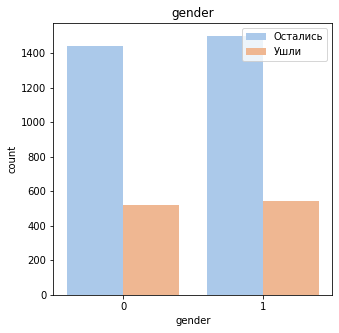

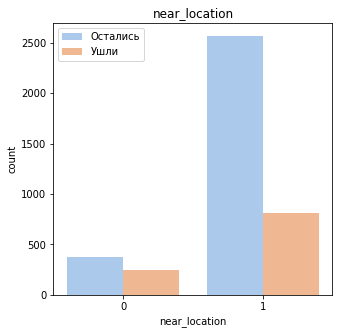

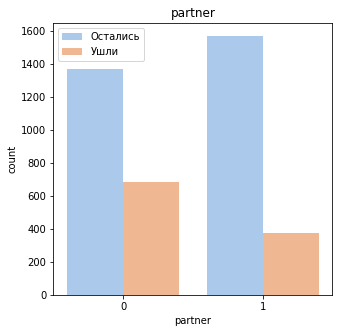

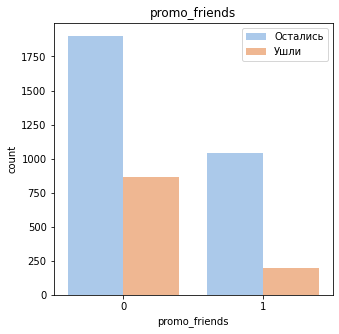

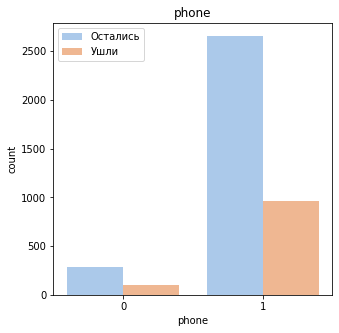

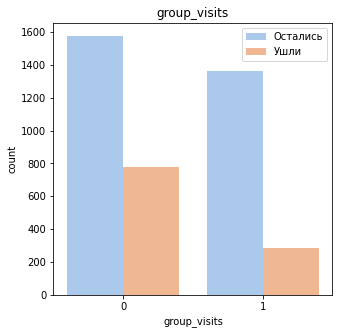

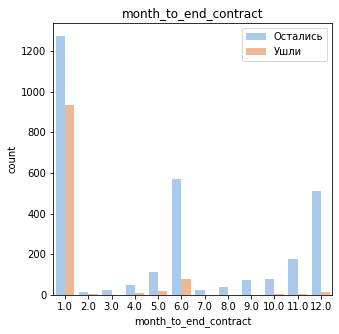

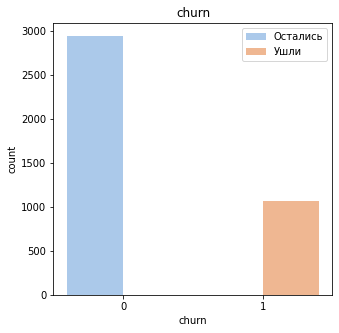

In [8]:
sns.set_palette('pastel')
for col in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'month_to_end_contract', 'churn']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = df[col], hue='churn', data=df)
    plt.legend(['Остались', 'Ушли'])
    plt.title(col)
    plt.show()

Выводы:
- пол пользователя не имеет значения: мужчины и женщниы распределились одинаково по тем, кто ушёл, и тем, кто остался.
- люди, которые живут или работают рядом с фитнес-центром, реже уходят.
- пользователи, которые пришли по партнёрским программам, заметно реже уходят.
- также и пользователи, пришедшие по рекомендации друга.
- предоставление или непредоставление телефона не влияет на то, останется ли человек.
- пользователи, посещающие групповые занятия, реже уходят.
- чаще всего люди уходят, когда у них остаётся месяц до окончания абонемента.
- количество оставшихся пользователей заметно превышает количество ушедших.

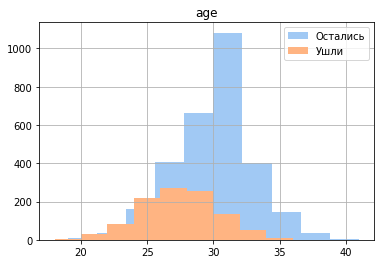

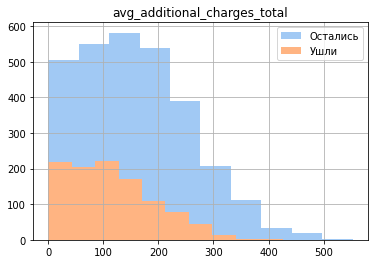

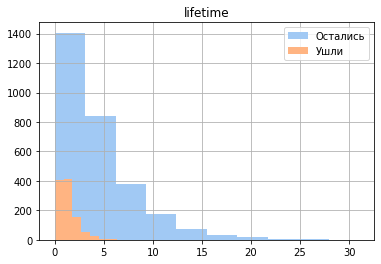

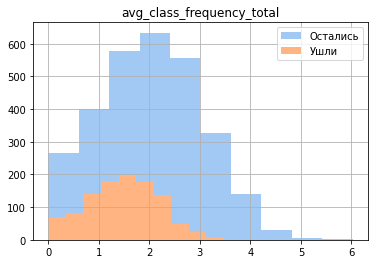

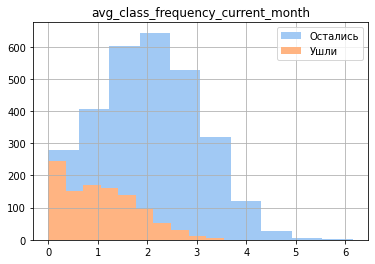

In [9]:
for col in df[['age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']]:
    df.query('churn == 0')[col].hist()
    df.query('churn == 1')[col].hist()
    plt.title(col)
    plt.legend(['Остались', 'Ушли'])
    plt.show()

Выводы:
- возраст основной массы оставшихся пользователей - 27-32 года. Возраст основной массы ушедших пользователей - 25-30 лет. Оба распределения близки к нормальному. У осташихся пользователей заметный пик в районе 30 лет.
- и оставшиеся, и ушедшие пользователи в основной массе тратят не более 200 у.е. Распределения первых и вторых очень похожи: оно более менее равномерно в промежутке от 0 до 200, а далее в обеих группах идёт на спад.
- лайтайм ушедших пользователей в основном не превышает 5 месяцев. В основном "жизнь" ушедшего клиента длится 1 месяц. Лайфтайм оставшихся пользователей растянулся от 1 до 30 месяцев. Основная масса - от до 10 месяцев.
- ушедшие пользователи реже тренеруются: пик распределения количества тренировок пользоватлей, которые ушли, - 1,5 тренировки в неделю. Пользователей, которые остались - 2 тренировки. 
- в полследнем месяце распределение количества тренировок оставшихся пользователей осталось таким же, а распределение тренировок ушедших изменилось: теперь пик приходится на ноль, а второй пик на 1 тренировку.

### Матрица корреляций

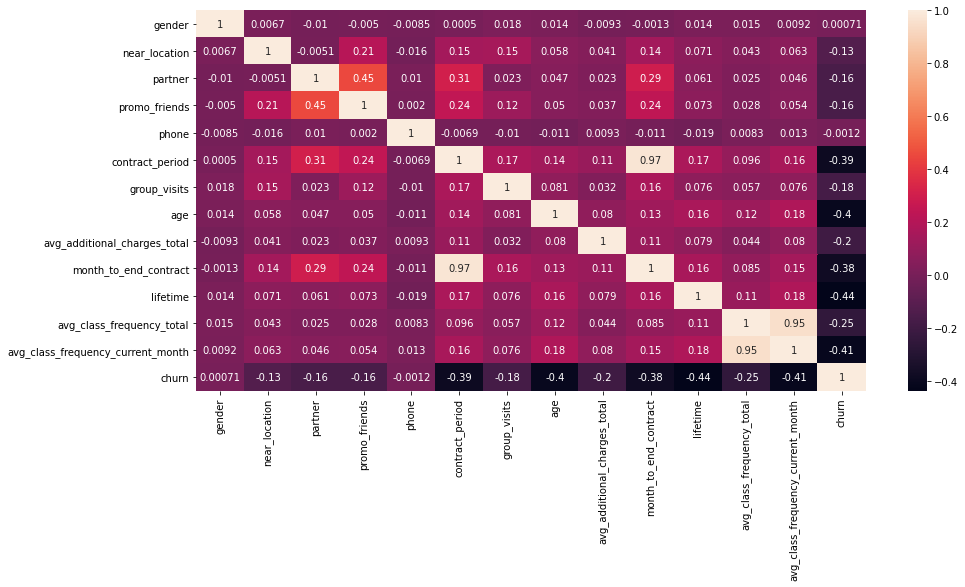

In [10]:
cm = df.corr()
fig, ax = plt.subplots(figsize=(15, 7))

sns.heatmap(cm, annot=True)
#ax.set_ylim(7, 0)
plt.show()

Выводы:
- в датасете есть мультиколлинеарные признаки: contract_period и month_to_end_contract, avg_class_frequency_current_month и avg_class_frequency_total. Для построения модели лучше такие признаки убрать.
- большинство признаков не имеют ярко выраженной зависимости друг от друга.
- у оттока есть некоторая корреляция со следующими признаками: contract_period, age, month_to_end_contract, lifetime и avg_class_frequency_current_month. Причём все эти признаки имеют отрицательную коррелицию. То есть, чем больше этот признак, тем меньше отток. Но влияние это не слишком велико.

In [11]:
# уберём мультиколлинеарные признаки

df = df.drop(['month_to_end_contract', 'avg_class_frequency_current_month'], axis=1)

## Модель прогнозирования оттока клиентов

### Создание моделей

In [13]:
#подготовим данные
X = df.drop('churn', axis = 1)
y = df['churn']

#разобьём данные на обучаюшую и валилационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#стандартизируем данные
scaler = StandardScaler()
scaler.fit(X_train)

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

#зададим алгоритм модели логистической регрессии
model_lr = LogisticRegression(solver='liblinear') 
#обучим модель
model_lr.fit(X_train_st, y_train)


#зададим алгоритм для новой модели на основе алгоритма случайного леса
model_rf = RandomForestClassifier(n_estimators = 100,random_state = 0)
#обучим модель
model_rf.fit(X_train, y_train)



#сделаем прогнозы двумя моделями
predictions_lr = model_lr.predict(X_test_st)
probabilities_lr = model_lr.predict_proba(X_test_st)[:,1]
predictions_rf = model_rf.predict(X_test)
probabilities_rf = model_rf.predict_proba(X_test)[:, 1]

### Расчёт метрик

In [17]:
#зададим функцию для расчёта метрик
def print_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    
#выведем метрики обеих моделей
print_metrics(
    y_test,
    predictions_lr,
    probabilities_lr,
    title='Метрики для модели логистической регрессии:',
)

print_metrics(
    y_test,
    predictions_rf,
    probabilities_rf,
    title='Метрики для модели случайного леса:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.81
Метрики для модели случайного леса:
	Accuracy: 0.89
	Precision: 0.78
	Recall: 0.77


Выводы:
- accuracy (точность): Обе модели показали хороший результат: 90 и 89%. Логистическая регрессия показала чуть лучший результат.
- precision (доля правильных ответов только среди целевого класса): 79% - логистическая регрессия и 78% - случайный лес. Тоже неплохие результаты. Логистическая регрессия опять немного лучше.
- recall (сколько реальных объектов класса мы смогли обнаружить с помощью модели): 81% - линейная регрессия и 77% - случайный лес. Здесь разница между моделями уже более заметна, и выигрывает опять логистическая регрессия.

Вывод однозначный: модель логистической регресси в данном случае подходит лучше. Метрики неплохие, поэтому модель можно применять в реальной жизни.

## Кластеризация клиентов

### Разбиение на кластеры

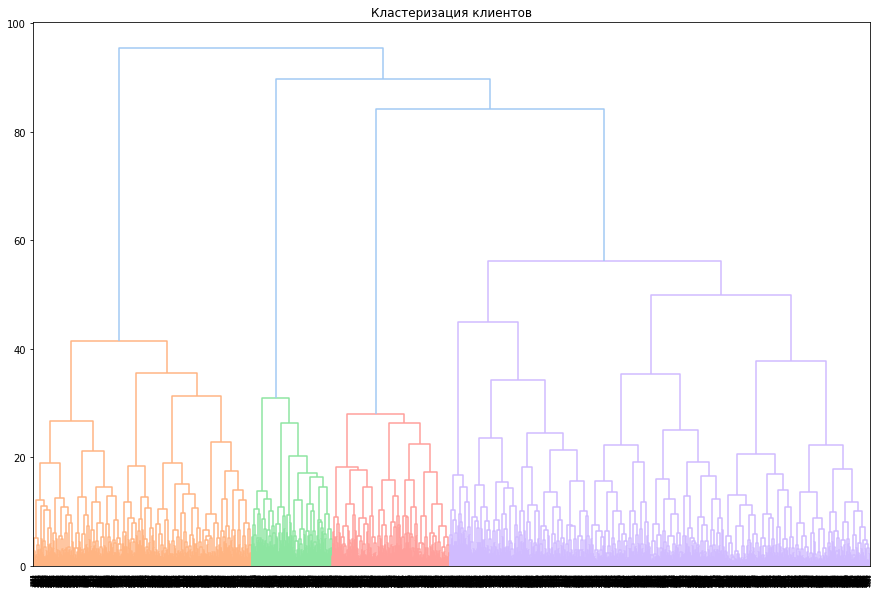

In [22]:
#стандартизируем данные
x_sc = scaler.fit_transform(df.drop(columns = ['churn']))
#построим матрицу расстояний
linked = linkage(x_sc, method = 'ward')
#построим дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов')
plt.show() 

Автоматически на графике определилось четыре кластера. Вероятно, из-за того, что четвёртый кластер очень большой, разделим пользователей на пять кластеров.

### Анализ признаков для кластеров

In [30]:
#задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters=5, random_state=0)
#прогнозируем кластеры для наблюдений
labels = km.fit_predict(x_sc)
#добавим поле с номером кластера в исходный датафрейм
df['cluster_km'] = labels

#средние значения признаков по кластерам
df.drop('churn', axis=1).groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total
cluster_km,,,,,,,,,,,
0,0.499109,0.000000,0.488414,0.076649,1.0,3.032086,0.235294,28.721925,137.540009,3.060606,1.770413
1,0.488571,0.995238,0.955238,0.892381,1.0,7.660952,0.458095,29.543810,155.861428,4.380952,1.978963
2,0.505300,1.000000,0.238516,0.059187,1.0,2.819788,0.000000,28.770318,143.383993,3.343640,1.800647
3,0.544202,1.000000,0.250287,0.079219,1.0,4.528129,1.000000,29.536165,148.088897,3.761194,1.941342
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211


Выводы:

Скорее всего, на распределение по кластерам не повлияли следующие признаки:
1. пол,
2. возраст,
3. стоимость доп. услуг,
4. лайфтайм,
5. частота тренировок.

Вероятно, на распределние повлияли признаки:
1. работа или жильё рядом с фитнес-центром,
2. абонемент по партнёрской программе,
3. абонемент по рекомендации друзей,
4. посещение групповых занятий.

Под вопросом:
1. наличие телефона в данных, 
2. длительность абонемента.

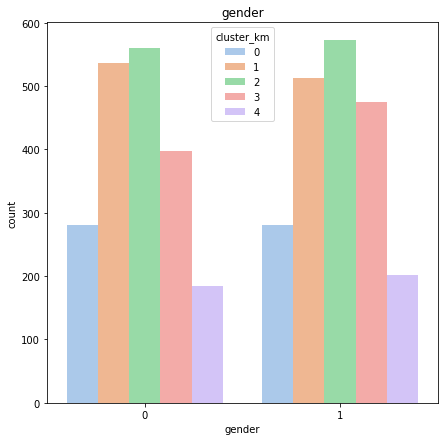

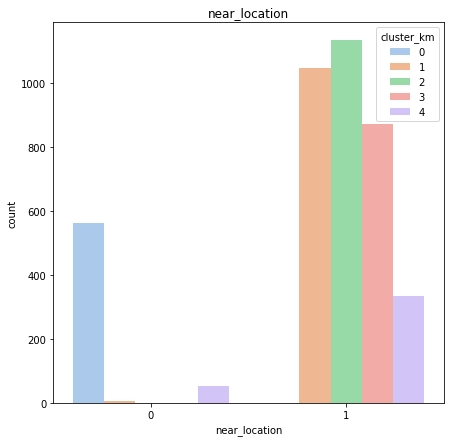

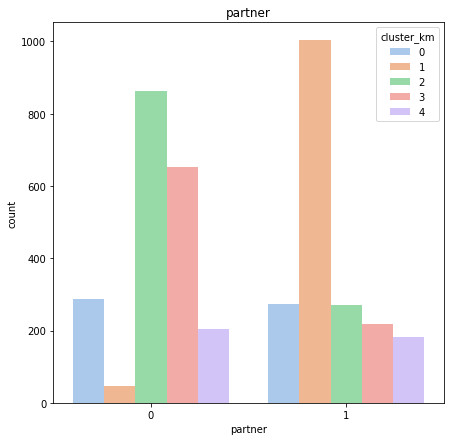

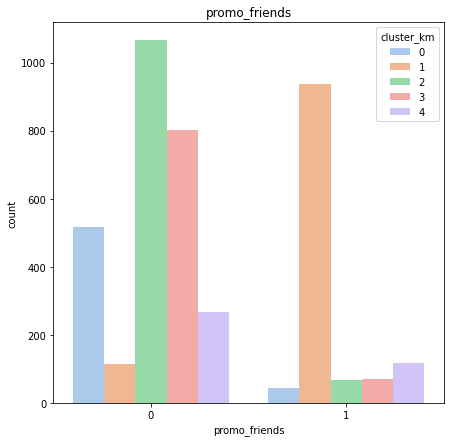

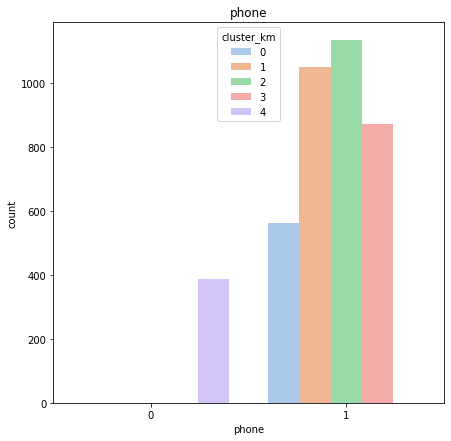

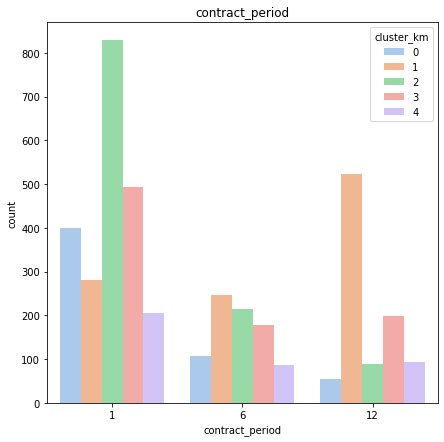

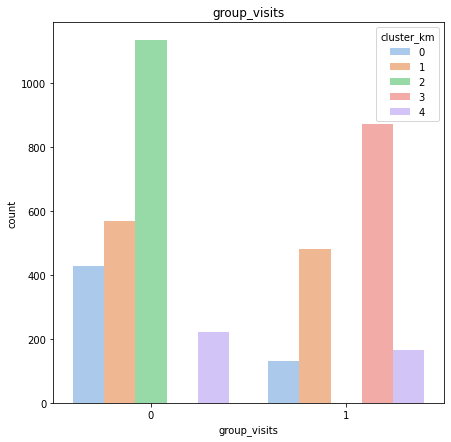

In [41]:
#построим распределения признаков по кластерам
#для дискретных признаков построим барплоты
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits']:
    plt.figure(figsize=(7, 7))
    sns.countplot(x = df[column], hue='cluster_km', data=df)
    plt.title(column)
    plt.show()

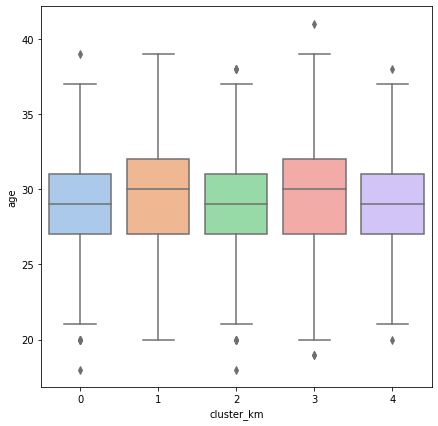

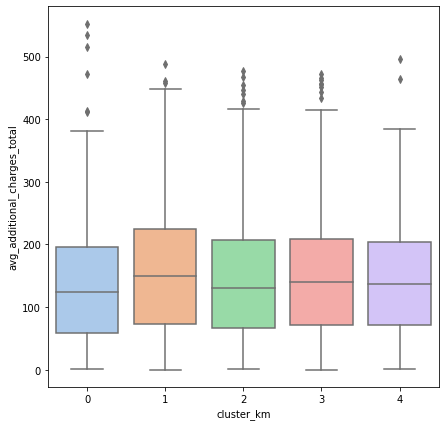

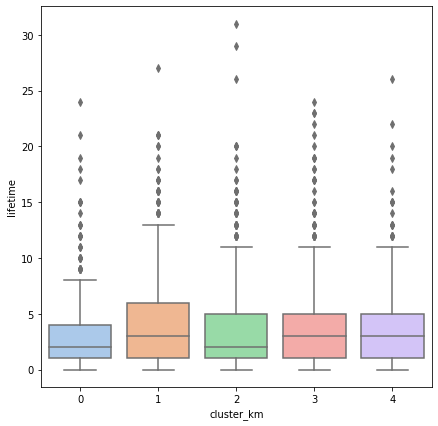

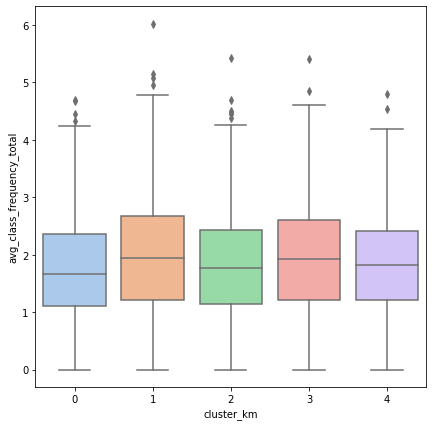

In [42]:
#для непрерывных величин построим боксплоты
for column in ['age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total']:
    plt.figure(figsize=(7, 7))
    sns.boxplot(x = 'cluster_km', y = df[column], data = df)
    plt.show()

Выводы:
1. пол посетителей распределился поровну в каждом кластере. Этот признак точно не влияет на то, в какой кластер попадёт пользователь.
2. жильё или работа у фитнес-центра, напротив, сильно влияет на то, в каком кластере окажется пользователь. Если пользователь не живёт и не работает у фитнес-центра, он скорее всего попадёт в нулевой кластер.
3. абонемент по партнёрской программе также влияет на распределение по кластерам. Так, если пользователь участвует в партнёрской программе, он вероятнее всего окажется в первом кластере.
4. если пользователь пришёл по рекомендации друга, он скоре всего также окажется в первом кластере.
5. если пользователь не оставил номер телефона, он окажется в четвёртом кластере.
6. пользователи, обладающие абонементом на 1 месяц, с большой вероятностью попадут во второй кластер.
7. те, кто не посещает групповые занятия, попадут во второй кластер, а те, кто посещает - в третий.

Что же касается остальных признаков, они не оказывают заметного влияния на то, в какой кластер попадёт пользователь.

### Доля оттока в каждом кластере

In [31]:
#для начала посмотрим, сколько пользователей в кажом кластере
df.drop('churn', axis=1).groupby('cluster_km').count()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total
cluster_km,,,,,,,,,,,
0,561,561,561,561,561,561,561,561,561,561,561
1,1050,1050,1050,1050,1050,1050,1050,1050,1050,1050,1050
2,1132,1132,1132,1132,1132,1132,1132,1132,1132,1132,1132
3,871,871,871,871,871,871,871,871,871,871,871
4,386,386,386,386,386,386,386,386,386,386,386


Самые многочисленные кластеры - 1 и 2 (1050 и 1132 пользователей). Почти в половину меньше пользователей попали в кластеры 0 и 4 (561 и 386). 3 кластер - 871 пользователь.

In [54]:
df.query('churn==1').groupby('cluster_km')['churn'].count()/df.groupby('cluster_km')['churn'].count()

cluster_km
0    0.399287
1    0.120952
2    0.381625
3    0.200918
4    0.266839
Name: churn, dtype: float64

Выводы

Меньше всего оттоку подвержен второй кластер - там доля ушедших пользователей составляет всего 12%. Самая большоая текучка в нулевом кластере - почти 40% ушедших пользователей. Недалеко ушёл второй кластер - 38% ушедших. Третий кластер - 20%, четвёртый - 27%.


Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?
Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

## Выводы и рекомендации

В первой части исследования мы провели предобработку имеющихся данных и изучили их. Из исследовательского анализа стали понятны основные характеристики посетителей фитнес-центра, а также какие признаки характерны для тех, кто уходит из фитнес-центра, а кто остаётся. Также рассчитали корреляцию оттока и остальных признаков.

Корреляция между признаками есть, но она выражена не слишком сильно.

Эти данные помогают предположить, какие пользователи более подвержены оттоку, а какие менее.

Чтобы в будущем уметь предсказывать, останется клиент в фитнес-клубе или нет, применили две модели машинного обучения: логистическую регрессию  и случайный лес. 

Обе модели показали себя эффективными, но **логистическая регрессия имеет более высокие показатели. Поэтому рекомендуется использовать её для прогнозирования оттока клиентов**.

Была проведена кластеризация клиентов. Было выявлено пять основных кластеров.

Типичный представитель **нулевого** кластера:
- *не живёт и не работает в районе, где расположен фитнес-центр*,
- с одинаковой долей вероятности мог прийти по партнёрской программе или без неё,
- с большой вероятностью пришёл не по рекомендации друзей,
- точно оставил свой номер телефона,
- с большой вероятностью купил абонемент на один месяц,
- скорее всего не ходит на групповые занятия.
Представителей этого кластера - 561, **% оттока - 39,9**.


Типичный представитель **первого** кластера:
- *живёт или работает в районе, где расположен фитнес-центр*,
- *почти наверняка пришёл по партнёрской программе или по рекомендации друга*,
- оставил свой номер телефона,
- *вероятнее обладает абонементом на 12 месяцев*,
- примерно с одинаковой вероятностью посещает или не посещает групповые занятия.
Представителей этого кластера - 1050, **% оттока - 12,1**.

Типичный представитель **второго** кластера:
- *живёт или работает в районе, где расположен фитнес-центр*,
- скорее всего пришёл не по партнёрской программе и не по рекомендации друга,
- оставил свой номер телефона,
- *вероятнее всего обладает абонементом на 1 месяц*,
- *не посещает групповые занятия*.
Представителей этого кластера - 1132, **% оттока - 38,1**.

Типичный представитель **третьего** кластера:
- *живёт или работает в районе, где расположен фитнес-центр*,
- скорее всего пришёл не по партнёрской программе и не по рекомендации друга,
- оставил свой номер телефона,
- *вероятнее всего обладает абонементом на 1 месяц*,
- *посещает групповые занятия.*
Представителей этого кластера - 871, **% оттока - 20,1**.

Типичный представитель **четвёртого** кластера:
- скорее всего живёт или работает в районе, где расположен фитнес-центр,
- с одинаковой долей вероятности мог прийти по партнёрской программе или без неё,
- скорее всего пришёл не по рекомендации друзей,
- *не оставил номер телефона*,
- с большой вероятностью купил абонемент на один месяц,
- примерно с одинаковой вероятностью посещает или не посещает групповые занятия.
Представителей этого кластера -  386, **% оттока - 26,7**.

По имеющимя данных клиентов, фитнес-центр может относить того или иного клиента к определенному кластеру. Зная, что для него характерно, можно разработать индивидуальные маркетинговые стратегии для каждого кластера.

Например, для самого надёжного первого кластера можно использовать меры вознаграждения за длительность пользования фитнес-центром, делать подарки или разработать более индивидуальный подход.

Для самого ненадёжного (и не слишком многочисленного) нулевого кластера, можно разработать более привлекательные графики тренировок, т.к. представители этого кластера не живут и не работают рядом с фитнес-центром.

Такой подход поможет удержать некоторых клиентов.

Анализируя основные признаки первого кластера, можно сказать, что партнёрские программы и программа "приведи друга" стимулируют людей оставаться. Можно продивать эти программы.

Также, имея возможность предсказать долю уходящих клиентов, бизнесу будет проще планировать бюджет в будущем.